In [46]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
import datetime as dt


In [47]:
#input_file ="Energy_2020_03_13_03_55_PM.csv"
out_filename = "processed_energy.csv"

In [48]:
data = pd.read_csv(out_filename, sep=",", error_bad_lines=False)

In [49]:
#data 
from IPython.display import display
pd.options.display.max_columns = None
display(data)

,ConsumedMegajoules,NodeName,Lowestkilojoules,Partitions,AvailableFeatures,SlurmdStartTime
0,14.455238,gpu01,327.905,gpu,"128gb,broadwell-ep,e5-2640v4",2020-03-06T14:56:42
1,22.178750,gpu02,89.486,gpu,"32gb,sandybridge-ep,e5-2665",2020-03-06T14:56:44
2,97.320117,node01,508.775,cmsp,"omnipart,128gb,broadwell-ep,e5-2640v4",2020-03-06T14:56:35
3,92.215966,node02,348.011,cmsp,"omnipart,128gb,broadwell-ep,e5-2640v4",2020-03-06T14:56:35
4,96.752409,node03,502.728,cmsp,"omnipart,128gb,broadwell-ep,e5-2640v4",2020-03-06T14:56:35
...,...,...,...,...,...,...
142,12.350000,node93,48.460,esp,"infiniband,64gb,ivybridge-ep,e5-2680v2",2020-03-06T14:56:35
143,48.090000,node109,75.480,esp1,"infiniband,64gb,ivybridge-ep,e5-2680v2",2020-03-06T14:56:35
144,19.450000,node132,149.120,long,"infiniband,64gb,ivybridge-ep,e5-2680v2",2020-03-06T14:56:36
145,16.310000,node133,134.120,long,"infiniband,64gb,ivybridge-ep,e5-2680v2",2020-03-06T14:56:37


In [50]:
#Compute time
# 2019-10-17T10:18:38
#starting_time = '2020-03-13 15:55'
a = dt.datetime.fromisoformat('2020-03-06T14:56:35')
starting_time = dt.datetime(2020, 3, 13, 15, 55)

def cal_time_diff(end, start = starting_time):
    return (start-end).total_seconds()

cal_time_diff(a)

608305.0

In [51]:
#calculate the duration from start date or enabling RAPL to disabling it.
def add_time_to_df(list_ending_time):
    df = []
    for x in list_ending_time.to_numpy():
        df.append(cal_time_diff(dt.datetime.fromisoformat(x)))  
    return  pd.DataFrame(df, columns =['period'])

data['period'] = add_time_to_df(data['SlurmdStartTime'])
data

,ConsumedMegajoules,NodeName,Lowestkilojoules,Partitions,AvailableFeatures,SlurmdStartTime,period
0,14.455238,gpu01,327.905,gpu,"128gb,broadwell-ep,e5-2640v4",2020-03-06T14:56:42,608298.0
1,22.178750,gpu02,89.486,gpu,"32gb,sandybridge-ep,e5-2665",2020-03-06T14:56:44,608296.0
2,97.320117,node01,508.775,cmsp,"omnipart,128gb,broadwell-ep,e5-2640v4",2020-03-06T14:56:35,608305.0
3,92.215966,node02,348.011,cmsp,"omnipart,128gb,broadwell-ep,e5-2640v4",2020-03-06T14:56:35,608305.0
4,96.752409,node03,502.728,cmsp,"omnipart,128gb,broadwell-ep,e5-2640v4",2020-03-06T14:56:35,608305.0
...,...,...,...,...,...,...,...
142,12.350000,node93,48.460,esp,"infiniband,64gb,ivybridge-ep,e5-2680v2",2020-03-06T14:56:35,608305.0
143,48.090000,node109,75.480,esp1,"infiniband,64gb,ivybridge-ep,e5-2680v2",2020-03-06T14:56:35,608305.0
144,19.450000,node132,149.120,long,"infiniband,64gb,ivybridge-ep,e5-2680v2",2020-03-06T14:56:36,608304.0
145,16.310000,node133,134.120,long,"infiniband,64gb,ivybridge-ep,e5-2680v2",2020-03-06T14:56:37,608303.0


In [52]:
# Change Megajoules to joules 
data['ConsumedMegajoules'] = data['ConsumedMegajoules']*1000000  #change Megajoules to joules 
data['power'] = data['ConsumedMegajoules']/ data['period']

In [53]:
#get number of nodes of a certain type
df = data.AvailableFeatures.value_counts()
df

infiniband,32gb,sandybridge-ep,e5-2620    47
infiniband,64gb,ivybridge-ep,e5-2680v2    45
omnipart,192,broadwell-ep,e5-2640v4       24
omnipart,128gb,broadwell-ep,e5-2640v4     16
infiniband,32gb,sandybridge-ep,e5-2650    10
32gb,sandybridge-ep,e5-2650                3
32gb,sandybridge-ep,e5-2665                1
128gb,broadwell-ep,e5-2640v4               1
Name: AvailableFeatures, dtype: int64

In [54]:
#get number of nodes grouped by Parttiions 
data.groupby('Partitions')['AvailableFeatures'].value_counts()

Partitions  AvailableFeatures                     
cmsp        omnipart,192,broadwell-ep,e5-2640v4       24
            omnipart,128gb,broadwell-ep,e5-2640v4     16
esp         infiniband,32gb,sandybridge-ep,e5-2620    35
            infiniband,64gb,ivybridge-ep,e5-2680v2     1
esp1        infiniband,64gb,ivybridge-ep,e5-2680v2    28
gpu         128gb,broadwell-ep,e5-2640v4               1
            32gb,sandybridge-ep,e5-2665                1
long        infiniband,64gb,ivybridge-ep,e5-2680v2    16
            infiniband,32gb,sandybridge-ep,e5-2620    12
            infiniband,32gb,sandybridge-ep,e5-2650    10
serial      32gb,sandybridge-ep,e5-2650                1
testing     32gb,sandybridge-ep,e5-2650                2
Name: AvailableFeatures, dtype: int64

In [55]:
# Get sum by partitition and features 
pf_pie_data = data.groupby(['Partitions', 'AvailableFeatures'])['power'].agg('sum')
pf_pie_data

Partitions  AvailableFeatures                     
cmsp        omnipart,128gb,broadwell-ep,e5-2640v4     2368.762704
            omnipart,192,broadwell-ep,e5-2640v4       3736.650131
esp         infiniband,32gb,sandybridge-ep,e5-2620     782.923908
            infiniband,64gb,ivybridge-ep,e5-2680v2      20.302315
esp1        infiniband,64gb,ivybridge-ep,e5-2680v2    1663.448807
gpu         128gb,broadwell-ep,e5-2640v4                23.763415
            32gb,sandybridge-ep,e5-2665                 36.460457
long        infiniband,32gb,sandybridge-ep,e5-2620     434.698860
            infiniband,32gb,sandybridge-ep,e5-2650     330.136759
            infiniband,64gb,ivybridge-ep,e5-2680v2    2364.205112
serial      32gb,sandybridge-ep,e5-2650                 69.293349
testing     32gb,sandybridge-ep,e5-2650                125.493779
Name: power, dtype: float64

In [56]:
#Get sum using agg per partition 
pie_data = data.groupby(['Partitions'])['power'].agg('sum')
pie_data

Partitions
cmsp       6105.412835
esp         803.226224
esp1       1663.448807
gpu          60.223872
long       3129.040731
serial       69.293349
testing     125.493779
Name: power, dtype: float64

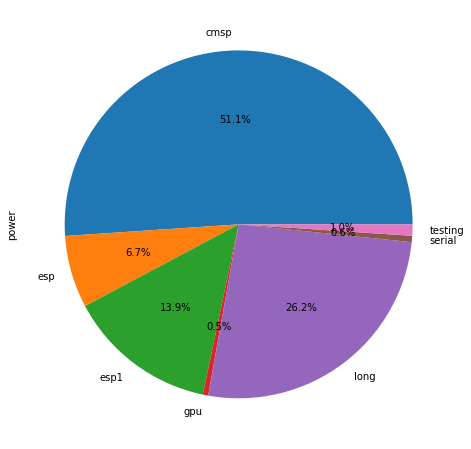

In [57]:
# Create power pie
plot1 = pie_data.plot.pie(subplots=True, autopct='%1.1f%%', startangle=0, figsize=(15, 8))